# 期中專案: 百貨業實習生日誌情緒分析
**Author:** 周紘樟、鍾君右、林妤姍、陳亞琦<br>
**Date created:** 2021/11/26<br>
**Last modified:** 2021/11/26<br>
希望可以透過實習生日誌的內容，分析他們的情緒變化，與實習狀態。

## 大綱
+ 1. 資料前處理
    + 1.1 基本資料介紹
    + 1.2 日期處理
    + 1.3 資料清理
    + 1.4 日誌內容斷詞
+ 2. lexicon-base 情緒分析
    + 2.1 準備台大情緒字典
    + 2.2 情緒字典與斷詞結果進行合併
    + 2.3 實習生各自的情緒分析
    + 2.4 依照月份的整體情緒走向
    + 2.5 文字雲
    + 2.6 情緒代表字
    + 2.7 歸類正負面文章
    + 2.8 情緒關鍵字
+ 3. 結論    

In [1]:
# 安裝會使用到的套件
# %pip install wordcloud

In [2]:
# 確認當前工作目錄
%pwd

'c:\\Users\\betty\\D\\資管所\\社群媒體分析\\期中專案'

In [3]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt 
# import matplotlib
# import re
# import jieba
# import jieba.analyse
# from datetime import datetime
# from wordcloud import WordCloud 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm

In [5]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 1. 資料前處理
處理實習生日誌的excel檔案，包含日期處理，加上員工編號。

### 1.1 基本資料介紹
- 資料來源: 百貨業的實習生日誌
- 資料集： `raw_data/Meta-1.csv`、`raw_data/Meta-2.csv`
- 資料時間： 2018/04~2021/05

主要分析實習生的情緒變化。本次主要針對以下方向分析：
1. 各個實習生在實習過程中的情緒變化？
2. 每個月實習生們的總體情緒走向?
3. 正面和負面時間點上的差異？
4. 正面和負面討論的情緒分數大約多少？

In [6]:
#匯入資料
MetaData1 = pd.read_csv('./raw_data/Meta-1.csv', encoding='UTF-8')
MetaData2 = pd.read_csv('./raw_data/Meta-2.csv', encoding='UTF-8')

In [7]:
print(f"共有 {MetaData1.shape[0]} 篇日誌") #(row,column)
MetaData1.head(3)

共有 354 篇日誌


,artDate,year,intern_id,content
0,12/05-12/11,109,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,12/12-12/18,109,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,12/19-12/25,109,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...


In [8]:
print(f"共有 {MetaData2.shape[0]} 篇日誌") #(row,column)
MetaData2.head(3)

共有 908 篇日誌


,artDate,intern_id,content
0,2018/7/8,18,7月開始是大四實習的第一個月，這個禮拜帶了兩個新人去公司上課，希望他們能順利通過考試。除了帶...
1,2018/7/15,18,7月開始是大四實習的第一個月，也帶了新人去上課，每天都約了客戶，閒暇的時間也有去內湖開發，內...
2,2018/7/22,18,7月開始是大四實習的第一個月，一樣每天都有行程，開發與見客戶。有客戶被抽到抽樣體檢，我帶著客...


### 1.2 日期處理
MetaData1 : 分割日期區間、民國年轉成西元年
MetaData2 : 中文格式轉換、民國年轉成西元年

#### MetaData1
- 調整日期格式:原本"artDate"欄位是日期的區間，所以用'-'分割兩個日期，再取得位於第一個的開始日期

In [9]:
MetaData1['artDate'] = MetaData1.artDate.apply(lambda x: x.split('-')[0])

In [10]:
#把"year"欄位的民國年轉成西元年
MetaData1['year'] = MetaData1.year.apply(lambda x: x + 1911)

In [11]:
#將年份欄位與開始日期合併
MetaData1['artDate'] = MetaData1['year'].apply(str) + '/' + MetaData1['artDate']

In [12]:
#刪除"year"欄位
MetaData1 = MetaData1.drop("year", axis = 1)

In [13]:
MetaData1.head(3)

,artDate,intern_id,content
0,2020/12/05,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,2020/12/12,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,2020/12/19,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...


#### MetaData2
- 將"artDate"欄位中的中文字(年、月、日)以"/"符號代替，並刪除字串的前4個字(年份)和倒數第一個"/"，只保留月份和日期

In [14]:
# MetaData2['artDate'] = MetaData2.artDate.apply(lambda x: re.sub('[\u4e00-\u9fa5]+', '/', str(x))[4:-1])

In [15]:
MetaData2.head(3)

,artDate,intern_id,content
0,2018/7/8,18,7月開始是大四實習的第一個月，這個禮拜帶了兩個新人去公司上課，希望他們能順利通過考試。除了帶...
1,2018/7/15,18,7月開始是大四實習的第一個月，也帶了新人去上課，每天都約了客戶，閒暇的時間也有去內湖開發，內...
2,2018/7/22,18,7月開始是大四實習的第一個月，一樣每天都有行程，開發與見客戶。有客戶被抽到抽樣體檢，我帶著客...


#### MetaData
- 合併MetaData1和MetaData2的資料

In [16]:
MetaData = MetaData1.append(MetaData2,ignore_index=True)

In [17]:
MetaData.head()

,artDate,intern_id,content
0,2020/12/05,1,開始在本店上班外，還要去別家店支援，每次支援的時候都只會想客群、客人、活動內容，活動內容好難...
1,2020/12/12,1,快到聖誕節了，每間店開始以了聖誕節的氣方以及裝飾，這禮拜不忘要跟客人推薦聖誕節蛋糕，但是自己...
2,2020/12/19,1,這個月開始要衝刺聖誕節蛋糕的預購，發現在一人店根本不知道到底活動內容以及折扣跟優惠，當客人詢...
3,2020/12/26,1,經歷了上禮拜的腸胃炎，這禮拜沒有完全復原就上工了，雖然生病的時候有發生了一些事情，但是想了想...
4,2021/01/02,1,經歷了聖誕節，接下來重點活動是春節了，春節禮盒、發糕，第一次知道我們原來有在做發糕，而且還有...


### 1.3 資料清理  
- 去除NA值
- 去除不是中文的字詞

In [18]:
# 移除內容為na值的資料
MetaData.dropna(subset = ["content"], inplace=True)

In [19]:
MetaData['content'] = MetaData.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', x))

In [20]:
MetaData.head(3)

,artDate,intern_id,content
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...
1,2020/12/12,1,快到聖誕節了每間店開始以了聖誕節的氣方以及裝飾這禮拜不忘要跟客人推薦聖誕節蛋糕但是自己站店還...
2,2020/12/19,1,這個月開始要衝刺聖誕節蛋糕的預購發現在一人店根本不知道到底活動內容以及折扣跟優惠當客人詢問時...


### 1.4 日誌內容斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [21]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
# jieba.load_userdict('./dict/user_dict.txt')
#新增stop words
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords= [line.strip() for line in f.readlines()]
# 參數形式手動加入停用字
user_stop = ["這週","真的","希望","禮拜", "東西", "特別", "很快", "一點", "那位"]
for i in user_stop:
    stopWords.append(i)

In [22]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [23]:
MetaData['word'] = MetaData.content.apply(getToken)

Building prefix dict from c:\Users\betty\D\資管所\社群媒體分析\期中專案\dict\dict.txt.big ...
Loading model from cache C:\Users\betty\AppData\Local\Temp\jieba.u1113642acd0517a97f06c3927518a439.cache
Loading model cost 0.952 seconds.
Prefix dict has been built successfully.


In [24]:
# 將word欄位展開
MetaData_token = MetaData.explode('word') 

In [25]:
#轉換日期格式
MetaData_token['artDate'] = pd.to_datetime(MetaData_token['artDate'], format="%Y/%m/%d")

In [26]:
MetaData_token.head(3)

,artDate,intern_id,content,word
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,本店
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,上班
0,2020-12-05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,別家


In [27]:
#計算每天不同字的詞頻
word_count = MetaData_token.groupby(['artDate','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head()

,artDate,word,size
19606,2019-05-01,工作,101
18305,2019-04-30,客人,91
16472,2019-04-19,客人,80
19538,2019-05-01,客人,66
10366,2018-11-10,客人,52


In [28]:
# 新增artMonth欄位記錄每月的字詞
MetaData_token['artMonth'] = MetaData_token.artDate.apply(lambda x: x.strftime("%Y-%m"))
MetaData_token['artMonth']

0       2020-12
0       2020-12
0       2020-12
0       2020-12
0       2020-12
         ...   
1261    2019-04
1261    2019-04
1261    2019-04
1261    2019-04
1261    2019-04
Name: artMonth, Length: 50783, dtype: object

In [29]:
#計算每月不同字的詞頻
word_count = MetaData_token.groupby(['artMonth','word'],as_index=False).size()
word_count.sort_values(by=['size'], ascending=False,inplace=True)  #排序
word_count = word_count[word_count['size']>3]  #過濾出現太少次的字
word_count.head()

,artMonth,word,size
11634,2019-04,客人,213
8340,2018-12,客人,135
8416,2018-12,工作,128
14047,2019-05,工作,113
3557,2018-09,客人,110


## 2. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 2.1 準備台大字典  
- 分為正向情緒與負向情緒

In [30]:
filepath = ['negative','positive']
d_ntusd = []
for file in filepath:
    filename = f"./dict/NTUSD/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_ntusd.append([f.read().split("\n"),file])

In [31]:
df_ntusd = pd.DataFrame(d_ntusd,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_ntusd

,word,sentiments
0,幹,negative
1,一下子爆發,negative
2,一下子爆發的一連串,negative
3,一巴掌,negative
4,一再,negative
...,...,...
11079,戀戀,positive
11080,驚喜,positive
11081,讚許,positive
11082,讚賞,positive


### 2.2 情緒字典與斷詞結果進行合併

In [32]:
# data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])
# plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
# plt.style.use("ggplot")     # 使用ggplot主題樣式

# plt.title('每天的發文數量')
# plt.xlabel('artDate')
# plt.xticks(rotation= 45, fontsize=11)
# plt.plot(data_datecount.index, data_datecount['count'].tolist())

### 2.3 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [33]:
#日誌和與台大情緒字典做合併
data_ntusd = pd.merge(MetaData_token, df_ntusd, on=['word'],how='left')

#算出每月情緒總和(sentiment_count)
sentiment_count = data_ntusd.groupby(['artMonth','sentiments'],as_index=False).size()
sentiment_count.head(10)

,artMonth,sentiments,size
0,2018-04,negative,19
1,2018-04,positive,10
2,2018-05,negative,23
3,2018-05,positive,61
4,2018-07,negative,294
5,2018-07,positive,609
6,2018-08,negative,147
7,2018-08,positive,254
8,2018-09,negative,309
9,2018-09,positive,469


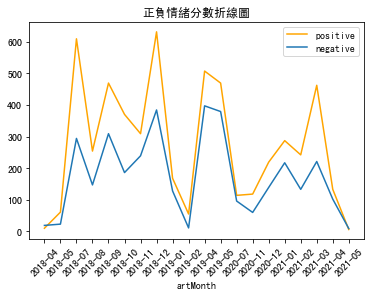

In [34]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式

plt.title('正負情緒分數折線圖')
plt.plot(p['artMonth'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artMonth'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artMonth')
plt.show()

### 2.4 正負向情緒分數比例折線圖圖

In [35]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artMonth'], as_index=False)
                                           .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

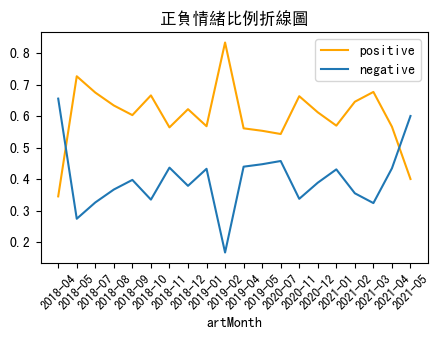

In [36]:
# sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] > '2021/03/13']
p = sentiment_count_r[sentiment_count_r['sentiments']=='positive']
n = sentiment_count_r[sentiment_count_r['sentiments']=='negative']

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式

plt.title('正負情緒比例折線圖')
plt.plot(p['artMonth'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artMonth'].tolist(), n['ratio'], label='negative')
plt.xticks(rotation= 45, fontsize=9)
plt.legend() #顯示圖例
# plt.axvline(x=datetime.strptime('2021-03-18', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-19', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-25', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-26', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artMonth')
plt.show()

### 2.5 文字雲
針對不同月分畫出該月的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

#### 整體的文字雲

In [37]:
def Wc_dict1(df, countB, countS):
    wc_df = (df.query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict

In [38]:
def Wc_dict2(df, Month, countB, countS):
    wc_df = (df.query('artMonth == @Month') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

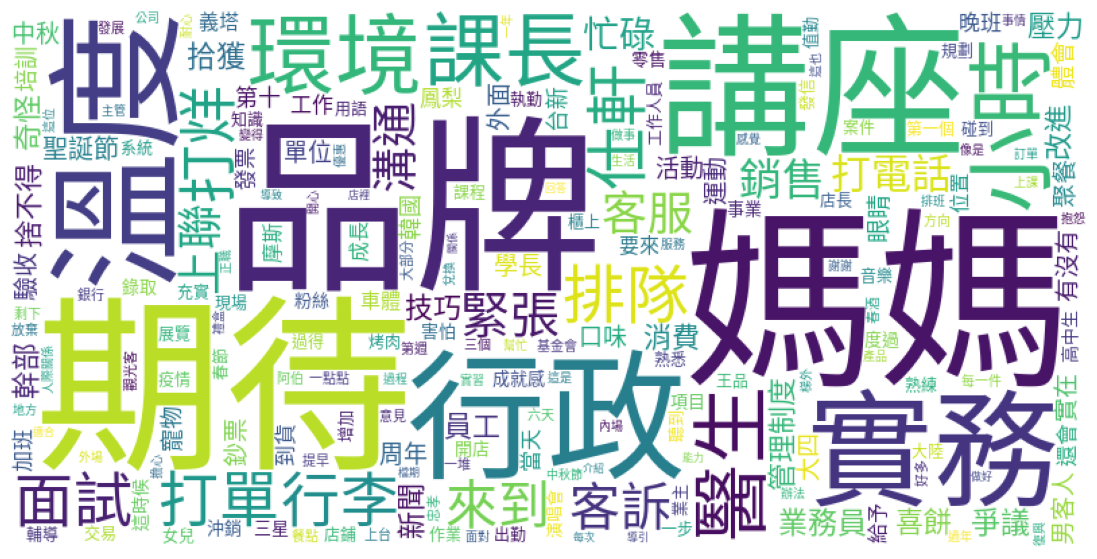

In [39]:
dict_all = Wc_dict1(word_count,450,5)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_all)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 月文字雲


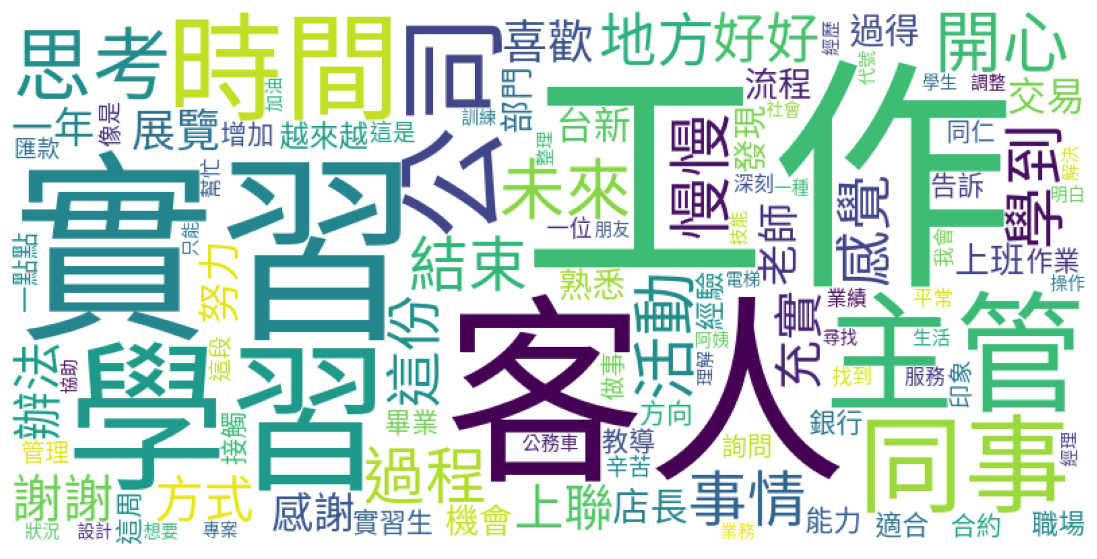

In [40]:
dict_03 = Wc_dict2(word_count,"2021-03",450,5)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_03)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 2.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [41]:
sentiment_sum = (word_count.merge(df_ntusd, on='word')
                 .groupby(['word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))
sentiment_sum = sentiment_sum.sort_values(by=['size'], ascending=False)  #排序
sentiment_sum.head()

,word,sentiments,size
42,學習,positive,393
29,喜歡,positive,234
140,開心,positive,154
59,感謝,positive,132
17,努力,positive,124


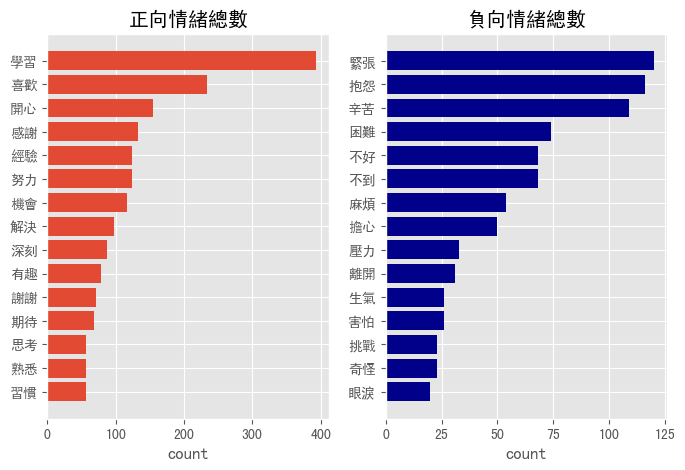

In [42]:
p_sum = sentiment_sum[sentiment_sum["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_sum[sentiment_sum["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

另外，也可以依據不同月分觀察情緒代表字的變化

In [43]:
sentiment_date_sum = (word_count.merge(df_ntusd, on='word')
                 .groupby(['artMonth', 'word', 'sentiments'], as_index=False)
                 .agg({'size': 'sum'}))

#篩選月份
sentiment_03 = sentiment_date_sum[sentiment_date_sum['artMonth']=="2021-03"].sort_values(by=['size'], ascending=False)
sentiment_03.head()

,artMonth,word,sentiments,size
412,2021-03,學習,positive,42
409,2021-03,喜歡,positive,22
414,2021-03,感謝,positive,22
442,2021-03,開心,positive,19
413,2021-03,思考,positive,19


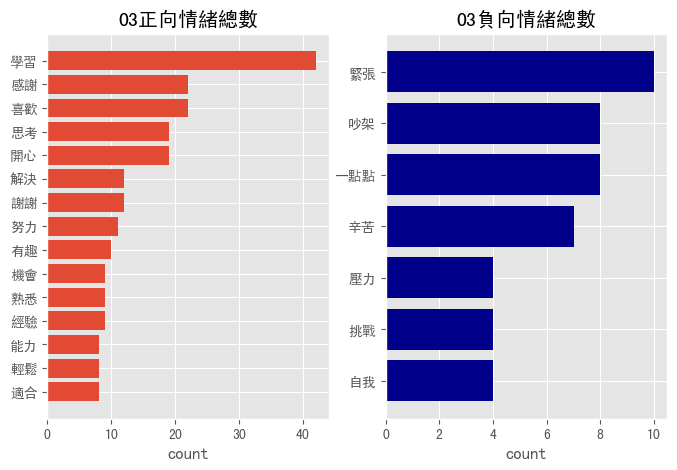

In [44]:
p_sum = sentiment_03[sentiment_03["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = sentiment_03[sentiment_03["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('03正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('03負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 2.7 歸類正負面文章
- 之前的情緒分析大部分是全部的詞彙加總，接下來將正負面情緒的文章分開，看看能不能發現一些新的東西。  
- 接下來歸類文章，將每一篇文章正負面情緒的分數算出來，然後大概分類文章屬於正面還是負面。

In [45]:
article_type = (MetaData_token.merge(df_ntusd, on='word')
                .groupby(['content', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='content', columns='sentiments', values='size', fill_value=0)
                .reset_index(['content'])
               )
article_type.head()

sentiments,content,negative,positive
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,1,0
1,一個學期好快就過了剛進來舊振南實習的時候還覺得想那麼多幹嘛時間還久嘛但一眨眼一學期半年就過去...,3,3
2,一個月真的過的挺快的新年的第一個月要過完了呢也代表快要迎接過年的長假來囉月底又開始越來越悠閒...,5,2
3,一整個晚上跑了整個小巨蛋會場沒有停下只因為違規的觀眾太多沒有時間停下來喝水但也因為要將違規者...,2,4
4,一整天都是站梯外的導引對我來說導引比開電梯還要不容易因為導引承擔很多東西像是顧客的情緒等等但...,0,2


In [46]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,418
1,positive,668


### 正負情緒文章數量統計圖

In [47]:
article_type_Month = article_type.merge(MetaData_token.loc[:,["content", "artMonth"]], how = 'left', on = 'content')
article_type_Month = article_type_Month.groupby(['artMonth','type'], as_index=False).size()
#article_type_date

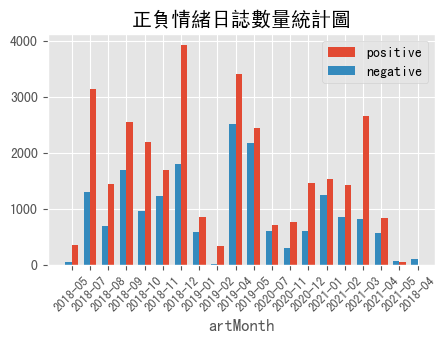

In [48]:
ap = article_type_Month[(article_type_Month["type"]=="positive")]
an = article_type_Month[(article_type_Month["type"]=="negative")]

plt.figure(figsize=(5,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.title('正負情緒日誌數量統計圖')
plt.xlabel('artMonth')
plt.bar(ap['artMonth'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artMonth'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(rotation= 45, fontsize=9)
plt.xlabel('artMonth')
plt.show()

### 2.8 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [49]:
positive_article = article_type[article_type["type"]=="positive"].merge(MetaData_token, how = 'left', on = 'content')
negative_article = article_type[article_type["type"]=="negative"].merge(MetaData_token, how = 'left', on = 'content')

### 情緒關鍵字:負面情緒文章

In [50]:
negative_article = (negative_article.merge(df_ntusd, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

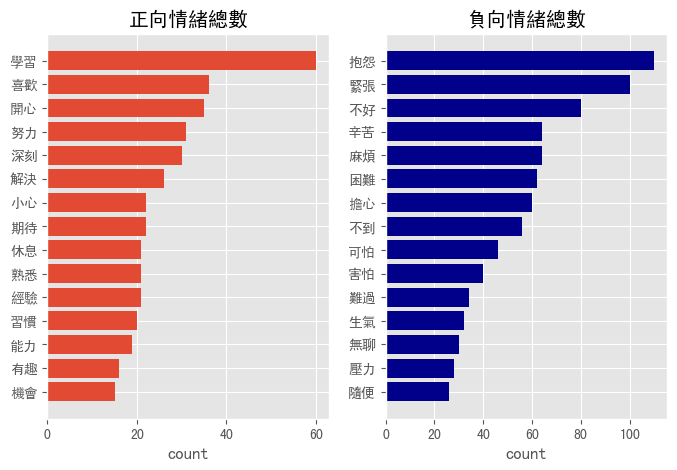

In [51]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

### 情緒關鍵字:正面情緒文章

In [52]:
positive_article = (positive_article.merge(df_ntusd, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

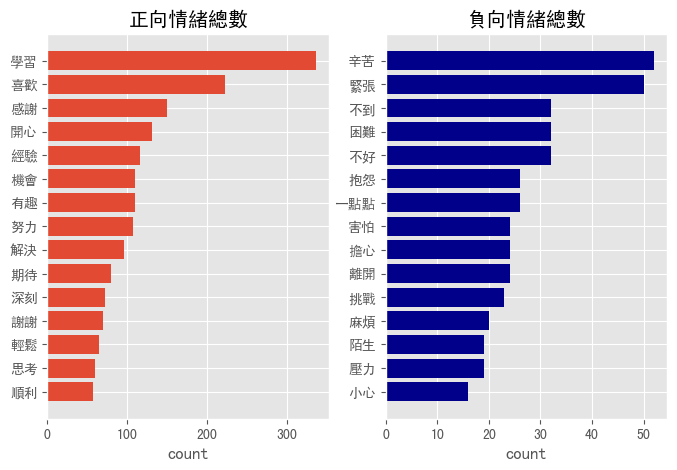

In [53]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

## 3. TF-IDF、bigram視覺化

### 3.1計算各詞彙在各文章中出現的次數

In [59]:
#計算各詞彙在各文章中出現的次數
dia_word_count = MetaData_token.groupby(['content','word'],as_index=False).size()
dia_word_count.rename(columns={'size': 'count'}, inplace=True)

In [60]:
dia_word_count

,content,word,count
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,上班,1
1,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,下班,1
2,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,休息時間,1
3,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,拾獲,1
4,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,時間,1
...,...,...,...
39576,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,開創,2
39577,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,開心,2
39578,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,關心,1
39579,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,難過,1


### 3.2計算每篇日誌的詞彙數量

In [61]:
total_words = MetaData_token.groupby(['content'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,content,total
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,8
1,一個學期好快就過了剛進來舊振南實習的時候還覺得想那麼多幹嘛時間還久嘛但一眨眼一學期半年就過去...,45
2,一個月真的過的挺快的新年的第一個月要過完了呢也代表快要迎接過年的長假來囉月底又開始越來越悠閒...,31
3,一整個晚上跑了整個小巨蛋會場沒有停下只因為違規的觀眾太多沒有時間停下來喝水但也因為要將違規者...,27
4,一整天都是站梯外的導引對我來說導引比開電梯還要不容易因為導引承擔很多東西像是顧客的情緒等等但...,22
...,...,...
1132,面對不一樣的環境有不一樣的挑戰而這次主要工作是松菸展覽順便介紹活動是由松山文創園區自行策畫之...,51
1133,面對不理性的客戶還是要保持我們的專業度運用表達同理心的有利說法不能被客戶牽著鼻子走就等他抱怨...,23
1134,領把我們這當能他家的儲藏室把我們的方便當隨便所以說這世界上什麼的人都有什,6
1135,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,47


### 3.3 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [62]:
dia_words = dia_word_count.merge(total_words,on = 'content',how = 'left')
dia_words

,content,word,count,total
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,上班,1,8
1,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,下班,1,8
2,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,休息時間,1,8
3,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,拾獲,1,8
4,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,時間,1,8
...,...,...,...,...
39576,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,開創,2,47
39577,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,開心,2,47
39578,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,關心,1,47
39579,馬上就要迎接年了時間過的真快我已經在王品實習半年了學到的東西也很多唯一很可惜的事情是義塔在年...,難過,1,47


### 3.4 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。  
        詞彙在該文件中出現次數 / 該文件中詞彙總數  
    - IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取log。評估詞彙在文集的獨特性  
        log( 總文件數量 / 包含該詞彙的文件數量 ) 

In [63]:
#計算tf
dia_words_tf_idf = dia_words.assign(tf = dia_words.iloc[:,2]/dia_words.iloc[:,3])

In [64]:
# 計算每個詞彙出現在幾篇文章中
idf_df = dia_words.groupby(['word'],as_index=False).size()
dia_words_tf_idf = dia_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [65]:
#計算idf
dia_words_tf_idf = dia_words_tf_idf.assign(idf = dia_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

dia_words_tf_idf = dia_words_tf_idf.drop(labels=['size'],axis=1)

In [66]:
#計算tf*idf
dia_words_tf_idf = dia_words_tf_idf.assign(tf_idf = dia_words_tf_idf.iloc[:,4]*dia_words_tf_idf.iloc[:,5])

In [67]:
dia_words_tf_idf.head()

,content,word,count,total,tf,idf,tf_idf
0,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,上班,1,8,0.125,0.694033,0.086754
1,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,下班,1,8,0.125,1.263369,0.157921
2,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,休息時間,1,8,0.125,1.941817,0.242727
3,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,拾獲,1,8,0.125,1.909632,0.238704
4,一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間,時間,1,8,0.125,0.686545,0.085818


### 3.5 檢視結果

In [68]:
# 選出每篇文章，tf-idf值最大的五個詞
group = dia_words_tf_idf.groupby("content").apply(lambda x : x.nlargest(5, "tf_idf"))

In [69]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
content                                                              
一下就下班了不只電梯爆炸服務台也人很多從上班忙到休息時間拾獲物都沒時間                6     爆炸  0.269084
                                                   2   休息時間  0.242727
                                                   3     拾獲  0.238704
                                                   1     下班  0.157921
                                                   7     電梯  0.150563
一個學期好快就過了剛進來舊振南實習的時候還覺得想那麼多幹嘛時間還久嘛但一眨眼一學期半年就過去了... 22    思潔  0.122432
                                                   16    學姐  0.101227
                                                   17    學期  0.087848
                                                   41    阿姨  0.076148
                                                   8     一北  0.067906
一個月真的過的挺快的新年的第一個月要過完了呢也代表快要迎接過年的長假來囉月底又開始越來越悠閒了... 48    再招  0.098573
                                                   58    挺快  0.098573
                                                   70    過年  0.088101
                                                   66    要過  0.079152
                                                   53    平均  0.076025

#### 計算整個文集中較常 tf-idf 值高的字

In [70]:
# 從每篇日誌挑選出tf-idf最大的十個詞
(dia_words_tf_idf.groupby("content").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
                                    # 計算每個詞被選中的次數
                                    .groupby(['word'],as_index=False).size()
                                    ).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
2662,客人,57
2667,客戶,33
7088,電梯,27
4328,服務,26
1993,喜餅,26
4657,活動,24
3052,店長,22
540,事情,21
6735,過年,16
3712,振南,16


## 4. 透過Jieba斷詞與N-gram幫助建立字典
N-gram 指文本中連續出現的n個語詞。 透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。  
N-gram範例：

### 4.1 Bigram

In [71]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [72]:
dia_bigram = MetaData.copy()
dia_bigram["word"] = dia_bigram.content.apply(bigram_getToken)

In [73]:
dia_bigram = dia_bigram.explode('word')
dia_bigram.head(3)

,artDate,intern_id,content,word
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,本店 上班
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,上班 別家
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,別家 支援


#### 統計最常出現的bigram組合

In [75]:
# 計算每個組合出現的次數
dia_bigram_count = dia_bigram.groupby(["word"],as_index=False).size()

In [76]:
# 清除包含英文或數字的bigram組合
wb_filter = list(dia_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
dia_bigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
14413,工作 內容,89
7265,印象 深刻,82
13463,實習 期間,71
34124,這份 工作,52
13515,實習 結束,39
11915,學習 工作,37
12445,客人 客人,35
34283,這是 振南,34
35352,還想 學習,32
22768,期間 印象,31


### 4.2 Trigram

In [77]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [79]:
dia_trigram = MetaData.copy()
dia_trigram["word"] = dia_trigram.content.apply(trigram_getToken)
dia_trigram = dia_trigram.explode('word')
dia_trigram.head(3)

,artDate,intern_id,content,word
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,本店 上班 別家
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,上班 別家 支援
0,2020/12/05,1,開始在本店上班外還要去別家店支援每次支援的時候都只會想客群客人活動內容活動內容好難想啊品項只...,別家 支援 每次


#### 統計最常出現的trigram組合

In [80]:
# 計算每個組合出現的次數
dia_trigram_count = dia_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
wb_filter = list(dia_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
dia_trigram_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
15043,實習 期間 印象,30
25325,期間 印象 深刻,30
13037,學習 工作 內容,29
16165,工作 內容 單位,28
4108,任職 企業 還想,28
10222,單位 實習 原因,28
4133,企業 還想 學習,28
38820,還想 學習 工作,28
5625,內容 單位 實習,28
7962,印象 深刻 一件,25


## 5. 建立Ngram預測模型
引入Markov假設，也就是當前的這個字僅僅與前幾個有限的字相關   
$$P(w_i|w_1,...,w_{i-1})=P(w_i|w_{i-m+1},...,w_{i-1})$$  
bi-gram (m=2):
$$ P(w_i|w_{i-1})=\frac {count(w_{i-1},w_i)} {count(w_{i-1})} $$   
tri-gram (m=3):  
$$ P(w_i|w_{i-2},w_{i-1})=\frac {count(w_{i-2},w_{i-1},w_i)} {count(w_{i-2},w_{i-1})} $$   


In [87]:
ngram_data = MetaData.copy()
sen_tokens = ngram_data.content.apply(getToken).tolist()
sen_tokens

[['本店',
  '上班',
  '別家',
  '支援',
  '每次',
  '支援',
  '只會',
  '客群',
  '客人',
  '活動',
  '內容',
  '活動',
  '內容',
  '好難',
  '品項',
  '搭配',
  '內容',
  '價格',
  '好難',
  '健康',
  '意識',
  '抬頭',
  '健康',
  '熱量',
  '不高',
  '客人',
  '可愛',
  '阿姨',
  '婆婆',
  '眼裡',
  '女兒',
  '孫女',
  '客人',
  '交朋友',
  '幸好',
  '介紹',
  '兒子',
  '孫子',
  '給我',
  '哈哈哈',
  '哈哈哈'],
 ['快到',
  '聖誕節',
  '每間',
  '聖誕節',
  '氣方',
  '裝飾',
  '不忘要',
  '客人',
  '推薦',
  '聖誕節',
  '蛋糕',
  '店還',
  '櫃位',
  '開心',
  '不用',
  '煩惱',
  '哈哈哈哈',
  '神奇',
  '客人',
  '客人',
  '推薦',
  '邀請',
  '直銷',
  '團體',
  '幸好',
  '一口氣',
  '拒絕',
  '多久',
  '結束',
  '短暫',
  '惡夢'],
 ['衝刺',
  '聖誕節',
  '蛋糕',
  '預購',
  '發現',
  '一人店',
  '活動',
  '內容',
  '折扣',
  '優惠',
  '客人',
  '詢問',
  '幸好',
  '店長',
  '幫忙',
  '解決問題',
  '腸胃炎',
  '休息',
  '三天',
  '生不如死',
  '上吐下瀉',
  '上班',
  '好幾輪',
  '謝謝',
  '上班',
  '同事',
  '特地',
  '永和',
  '上班',
  '短短',
  '小時',
  '體會',
  '到平',
  '常時',
  '同事',
  '關係'],
 ['經歷',
  '腸胃炎',
  '復原',
  '上工',
  '生病',
  '發生',
  '事情',
  '有意',
  '人上',
  '六天',
  '整天',
  '店長',
  '感受',
  '歉意',


In [89]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        #加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [90]:
#Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

**預測下一個出現的詞**

In [92]:
text = '實習'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 期間, probability: 0.119
next word: 結束, probability: 0.0651
next word: 原因, probability: 0.0467
next word: 過程, probability: 0.0267
next word: 工作, probability: 0.0267


## 6. Bigram視覺化

In [93]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [94]:
dia_bigram2 = MetaData.copy()
dia_bigram2["word"] = dia_bigram2.content.apply(bigram_getToken_dict)

In [95]:
dia_bigram2 = dia_bigram2.explode('word')
# water_bigram2.head(3)

In [96]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('工作', '內容'), 89),
 (('印象', '深刻'), 82),
 (('實習', '期間'), 71),
 (('這份', '工作'), 52),
 (('實習', '結束'), 39)]

In [97]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d = {k:v for k,v in bigramfdist.most_common(30)}

In [98]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.3 for w in  G.edges(data=True)]

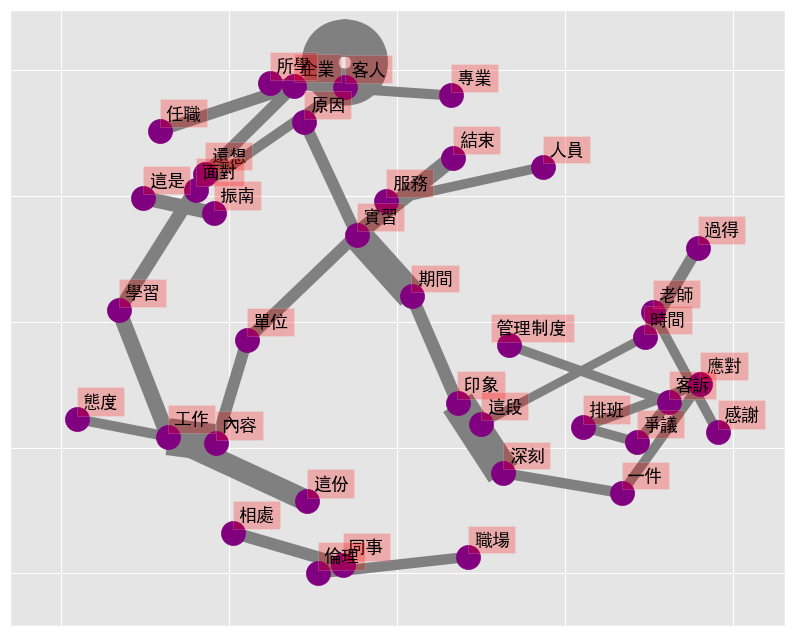

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## 7. Pairwise correlation
計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  

In [100]:
#取常一起出現的bigram pair 前500筆
b = {k:v for k,v in bigramfdist.most_common(500)}
# b.items()

In [101]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [102]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(dia_word_count[dia_word_count["word"]==df["word"]]["content"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(dia_word_count[dia_word_count["word"]==df["word2"]]["content"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(dia_word_count[dia_word_count["word"]==df["word"]]["content"]) #單獨有x
    y_ls = list(dia_word_count[dia_word_count["word"]==df["word2"]]["content"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["content"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [103]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [104]:
bigram_df

,word,word2,n,cor
0,工作,內容,89,0.200834
1,印象,深刻,82,0.686935
2,實習,期間,71,0.176631
3,這份,工作,52,0.226486
4,實習,結束,39,0.215523
...,...,...,...,...
495,解決,事情,4,0.028787
496,開心,成就感,4,0.115905
497,早餐,阿姨,4,0.186577
498,說話,方式,4,0.078929


### 8.1 和 實習, 工作 相關性最高的 15 個詞彙

In [105]:
c_sum = bigram_df[(bigram_df["word"]=="實習")].sort_values(by=['cor'], ascending = False).head(15)
b_sum = bigram_df[(bigram_df["word"]=="工作")].sort_values(by=['cor'], ascending = False).head(15)

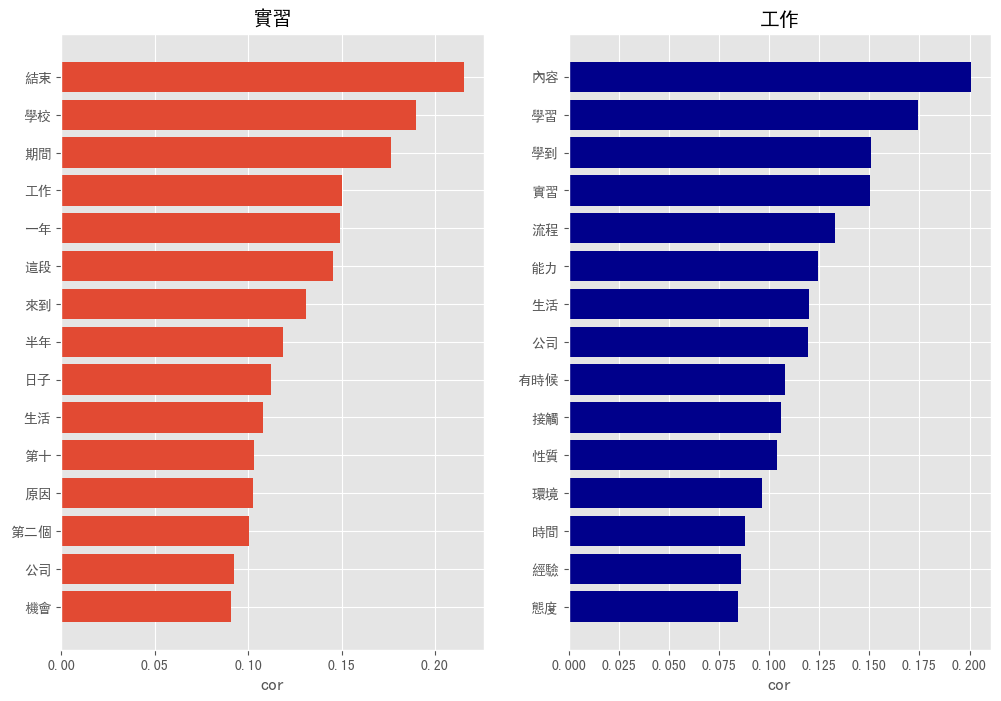

In [106]:
c_sum = c_sum.sort_values(by=['cor'])
b_sum = b_sum.sort_values(by=['cor'])

plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('實習')
plt.xlabel('cor')
plt.barh(c_sum['word2'],c_sum['cor'])

plt.subplot(122)
plt.title('工作')
plt.xlabel('cor')
plt.barh(b_sum['word2'],b_sum['cor'],color="darkblue")


plt.show()

### 8.2 使用詞彙關係圖畫出相關性大於0.4的組合

In [107]:
bigram_df[bigram_df["cor"]>0.4]

,word,word2,n,cor
1,印象,深刻,82,0.686935
12,任職,企業,28,0.539642
13,企業,還想,28,0.509087
17,職場,倫理,25,0.537246
26,排班,爭議,23,0.643652
27,爭議,客訴,23,0.428011
28,客訴,管理制度,23,0.408066
33,效益,所學,21,0.568011
43,交易,算錯,18,0.669541
44,算錯,錢給,18,0.824386


In [108]:
word_cors = bigram_df[bigram_df["cor"]>0.4]
word_cors.reset_index(inplace=True, drop=True)

In [109]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*10 for w in  g.edges(data=True)]

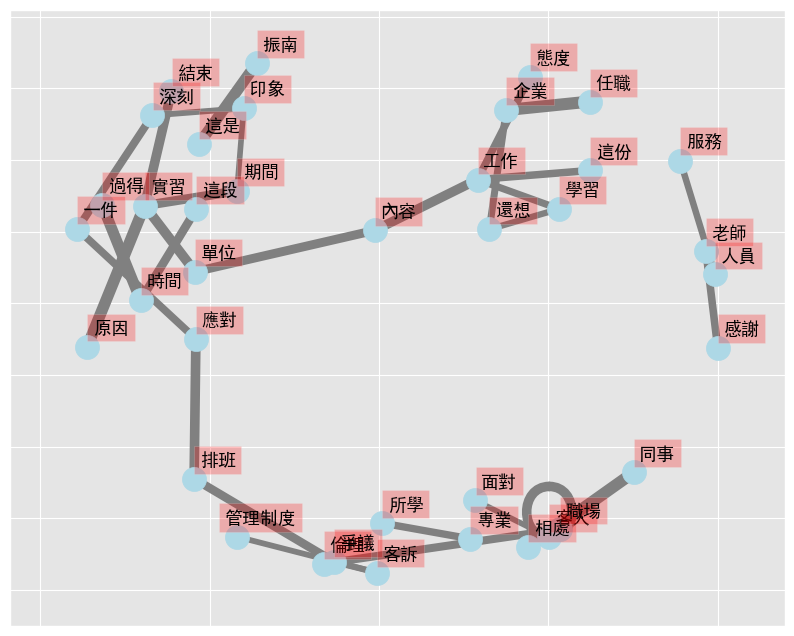

In [110]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()